In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('mwp1_CAT12_DELCODE/Antrag 137_Teipel_Regional Connectivity_20190429_Amendment_MDedit.xlsx', sheet_name='Baseline', header=1)
#print(df)
sid = df['Respeudonym']
grp = df['prmdiag']
age = df['age']
sex = df['sex_bin_1female']
tiv = df['TIV_CAT12']
field = df['FieldStrength']
grpbin = (grp > 0) # 0=CN, ...
amybin = df['ratio_Abeta42_40_pos']

In [2]:
# Scan for nifti file names
import glob
dataDELCODE_CN = sorted(glob.glob('mwp1_CAT12_DELCODE/0_CN/*.nii.gz'))
dataDELCODE_MCI = sorted(glob.glob('mwp1_CAT12_DELCODE/2_MCI/*.nii.gz'))
dataDELCODE_AD = sorted(glob.glob('mwp1_CAT12_DELCODE/5_AD/*.nii.gz'))
dataFiles = dataDELCODE_CN + dataDELCODE_MCI + dataDELCODE_AD
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  474  nifti files


In [3]:
# Match covariate information
import re
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%s' % id, x)] # extract ID numbers from filename, translate to Excel row index
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]
amy_status = pd.DataFrame({'amy_pos':amybin}).iloc[cov_idx, :]

Using TensorFlow backend.


Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load residualized data from disk
import h5py
hf = h5py.File('residuals_DELCODE_wb_mwp1_CAT12_MNI.hdf5', 'r')
hf.keys # read keys
images = np.array(hf.get('images'))
hf.close()
print(images.shape)

(474, 100, 100, 120, 1)


In [5]:
# determine amyloid status
amy_filter = np.equal(np.transpose(amy_status.to_numpy()), labels[:,1])
# filter index vector by amy status
test_idX = np.array(range(amy_filter.shape[1]))[np.squeeze(amy_filter)] 
grps = grps.iloc[test_idX, :]
images = images[test_idX, :]
labels = labels[test_idX, :]
print(images.shape)

(164, 100, 100, 120, 1)


In [6]:
# specify version of tensorflow
#%tensorflow_version 1.x  # <- use this for Google colab
import tensorflow as tf
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
print(tf.__version__)

# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True

1.15.4


In [7]:
# helper function to obtain performance result values
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((ppv * sen) / (ppv + sen))
    bacc = (spec + sen) / 2
    return bacc, sen, spec, ppv, npv, f1

validating model model_checkpoints/resmodel_wb_cv1.best.hdf5


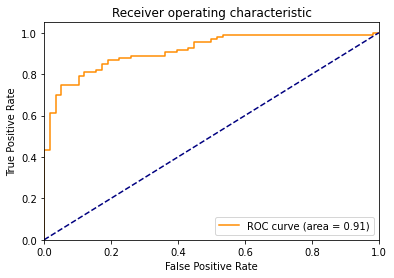

AUC for MCI vs. CN = 0.864
AUC for AD vs. CN = 0.972
Acc for MCI vs. CN = 79.1
Acc for AD vs. CN = 86.9
confusion matrix
[[46 12]
 [ 0  0]
 [12 45]
 [ 2 47]]
validating model model_checkpoints/resmodel_wb_cv2.best.hdf5


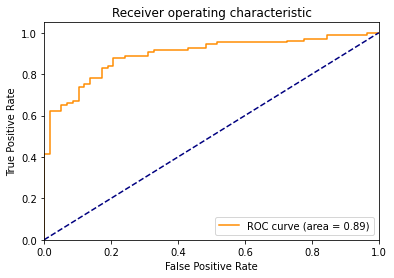

AUC for MCI vs. CN = 0.841
AUC for AD vs. CN = 0.956
Acc for MCI vs. CN = 80.0
Acc for AD vs. CN = 84.1
confusion matrix
[[44 14]
 [ 0  0]
 [ 9 48]
 [ 3 46]]
validating model model_checkpoints/resmodel_wb_cv3.best.hdf5


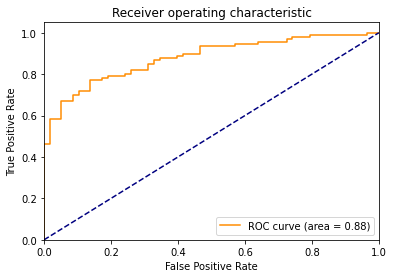

AUC for MCI vs. CN = 0.817
AUC for AD vs. CN = 0.950
Acc for MCI vs. CN = 67.8
Acc for AD vs. CN = 73.8
confusion matrix
[[31 27]
 [ 0  0]
 [10 47]
 [ 1 48]]
validating model model_checkpoints/resmodel_wb_cv4.best.hdf5


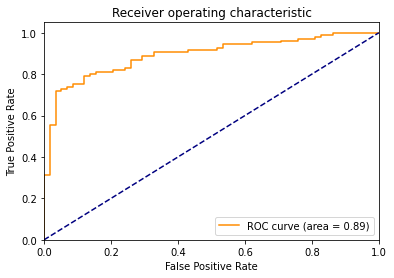

AUC for MCI vs. CN = 0.837
AUC for AD vs. CN = 0.957
Acc for MCI vs. CN = 76.5
Acc for AD vs. CN = 83.2
confusion matrix
[[43 15]
 [ 0  0]
 [12 45]
 [ 3 46]]
validating model model_checkpoints/resmodel_wb_cv5.best.hdf5


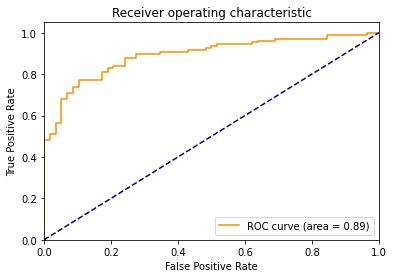

AUC for MCI vs. CN = 0.830
AUC for AD vs. CN = 0.964
Acc for MCI vs. CN = 75.7
Acc for AD vs. CN = 79.4
confusion matrix
[[38 20]
 [ 0  0]
 [ 8 49]
 [ 2 47]]
validating model model_checkpoints/resmodel_wb_cv6.best.hdf5


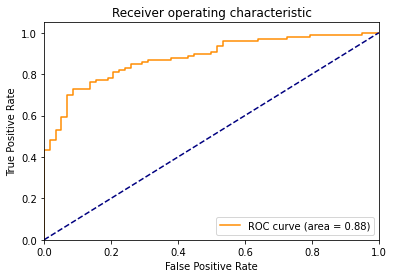

AUC for MCI vs. CN = 0.824
AUC for AD vs. CN = 0.944
Acc for MCI vs. CN = 74.8
Acc for AD vs. CN = 81.3
confusion matrix
[[41 17]
 [ 0  0]
 [12 45]
 [ 3 46]]
validating model model_checkpoints/resmodel_wb_cv7.best.hdf5


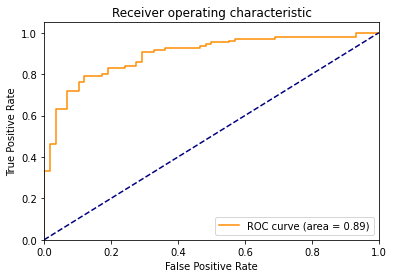

AUC for MCI vs. CN = 0.836
AUC for AD vs. CN = 0.963
Acc for MCI vs. CN = 75.7
Acc for AD vs. CN = 81.3
confusion matrix
[[39 19]
 [ 0  0]
 [ 9 48]
 [ 1 48]]
validating model model_checkpoints/resmodel_wb_cv8.best.hdf5


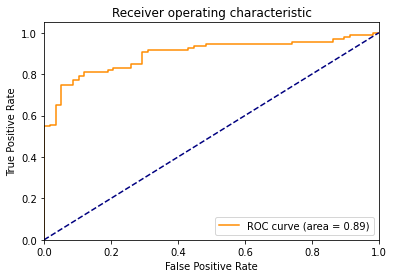

AUC for MCI vs. CN = 0.830
AUC for AD vs. CN = 0.970
Acc for MCI vs. CN = 74.8
Acc for AD vs. CN = 86.9
confusion matrix
[[46 12]
 [ 0  0]
 [17 40]
 [ 2 47]]
validating model model_checkpoints/resmodel_wb_cv9.best.hdf5


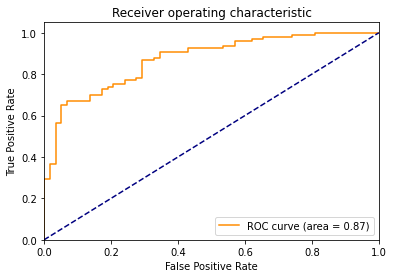

AUC for MCI vs. CN = 0.798
AUC for AD vs. CN = 0.956
Acc for MCI vs. CN = 72.2
Acc for AD vs. CN = 77.6
confusion matrix
[[35 23]
 [ 0  0]
 [ 9 48]
 [ 1 48]]
validating model model_checkpoints/resmodel_wb_cv10.best.hdf5


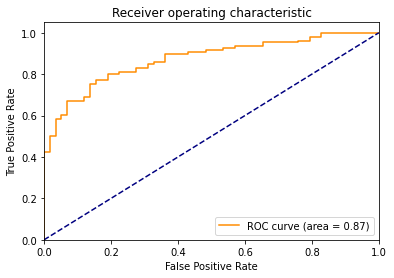

AUC for MCI vs. CN = 0.819
AUC for AD vs. CN = 0.933
Acc for MCI vs. CN = 72.2
Acc for AD vs. CN = 76.6
confusion matrix
[[37 21]
 [ 0  0]
 [11 46]
 [ 4 45]]


In [8]:
# validation
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras import models
import tensorflow as tf
from sklearn.metrics import confusion_matrix

acc_AD, acc_MCI, auc_AD, auc_MCI = [], [], [], []
bacc_AD, bacc_MCI = [], []
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
f1_AD, f1_MCI = [], []

num_kfold = 10 # number of cross-validation loops equal to number of models
batch_size = 20

for k in range(num_kfold):
    print('validating model model_checkpoints/resmodel_wb_cv%d.best.hdf5' % (k+1))
    mymodel = models.load_model('model_checkpoints/resmodel_wb_cv%d.best.hdf5' % (k+1))
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(images, batch_size=batch_size)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [2,5]:
      grpi = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(grps.Group.to_numpy(dtype=np.int), np.zeros((grps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], _ = roc_curve(labels[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      acc[i] = np.mean((labels[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100

    print('AUC for MCI vs. CN = %0.3f' % roc_auc[2])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[5])
    print('Acc for MCI vs. CN = %0.1f' % acc[2])
    print('Acc for AD vs. CN = %0.1f' % acc[5])
    auc_AD.append(roc_auc[5])
    auc_MCI.append(roc_auc[2])
    acc_AD.append(acc[5])
    acc_MCI.append(acc[2])
    
    print('confusion matrix')
    confmat = confusion_matrix(grps.Group, np.round(pred[:, 1]))
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    bacc_MCI.append(bacc); sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    bacc, sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    bacc_AD.append(bacc); sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)
    print(confmat[:,(0,1)])

In [9]:
# print model performance summary
from statistics import mean,stdev

print('Mean AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('Mean AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))
print('Mean Acc for MCI vs. CN = %0.3f +/- %0.3f' % (mean(acc_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.3f +/- %0.3f' % (mean(acc_AD), stdev(acc_AD)))
print('Mean Bacc for MCI vs. CN = %0.3f +/- %0.3f' % (mean(bacc_MCI), stdev(bacc_MCI)))
print('Mean Bacc for AD vs. CN = %0.3f +/- %0.3f' % (mean(bacc_AD), stdev(bacc_AD)))
print('Mean Sen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(sen_MCI)))
print('Mean Sen for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(sen_AD)))
print('Mean Spec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(spec_MCI), stdev(spec_MCI)))
print('Mean Spec for AD vs. CN = %0.3f +/- %0.3f' % (mean(spec_AD), stdev(spec_AD)))
print('Mean PPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(ppv_MCI), stdev(ppv_MCI)))
print('Mean PPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(ppv_AD), stdev(ppv_AD)))
print('Mean NPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(npv_MCI), stdev(npv_MCI)))
print('Mean NPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(npv_AD), stdev(npv_AD)))
print('Mean F1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(f1_MCI), stdev(f1_MCI)))
print('Mean F1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(f1_AD), stdev(f1_AD)))

Mean AUC for MCI vs. CN = 0.830 +/- 0.017
Mean AUC for AD vs. CN = 0.956 +/- 0.012
Mean Acc for MCI vs. CN = 74.870 +/- 3.537
Mean Acc for AD vs. CN = 81.121 +/- 4.335
Mean Bacc for MCI vs. CN = 0.749 +/- 0.035
Mean Bacc for AD vs. CN = 0.822 +/- 0.040
Mean Sen for MCI vs. CN = 0.809 +/- 0.046
Mean Sen for AD vs. CN = 0.955 +/- 0.021
Mean Spec for MCI vs. CN = 0.690 +/- 0.085
Mean Spec for AD vs. CN = 0.690 +/- 0.085
Mean PPV for MCI vs. CN = 0.723 +/- 0.049
Mean PPV for AD vs. CN = 0.726 +/- 0.053
Mean NPV for MCI vs. CN = 0.787 +/- 0.031
Mean NPV for AD vs. CN = 0.949 +/- 0.023
Mean F1 for MCI vs. CN = 0.762 +/- 0.027
Mean F1 for AD vs. CN = 0.824 +/- 0.033


In [10]:
results = pd.DataFrame({'AUC_MCI':auc_MCI, 'Acc_MCI':acc_MCI, 'Bacc_MCI':bacc_MCI, 'f1_MCI':f1_MCI,
                        'sen_MCI':sen_MCI, 'spec_MCI':spec_MCI, 'ppv_MCI':ppv_MCI, 'npv_MCI':npv_MCI,
                        'AUC_AD':auc_AD, 'Acc_AD':acc_AD, 'Bacc_AD':bacc_AD, 'f1_AD':f1_AD,
                        'sen_AD':sen_AD, 'spec_AD':spec_AD, 'ppv_AD':ppv_AD, 'npv_AD':npv_AD})
print(results)
results.to_csv('results_xval_DELCODE_amy_checkpoints.csv')

    AUC_MCI    Acc_MCI  Bacc_MCI    f1_MCI   sen_MCI  spec_MCI   ppv_MCI  \
0  0.864186  79.130435  0.791289  0.789474  0.789474  0.793103  0.789474   
1  0.841198  80.000000  0.800363  0.806723  0.842105  0.758621  0.774194   
2  0.816999  67.826087  0.679522  0.717557  0.824561  0.534483  0.635135   
3  0.836661  76.521739  0.765426  0.769231  0.789474  0.741379  0.750000   
4  0.830006  75.652174  0.757411  0.777778  0.859649  0.655172  0.710145   
5  0.824259  74.782609  0.748185  0.756303  0.789474  0.706897  0.725806   
6  0.836056  75.652174  0.757260  0.774194  0.842105  0.672414  0.716418   
7  0.829704  74.782609  0.747429  0.733945  0.701754  0.793103  0.769231   
8  0.797943  72.173913  0.722777  0.750000  0.842105  0.603448  0.676056   
9  0.818512  72.173913  0.722474  0.741935  0.807018  0.637931  0.686567   

    npv_MCI    AUC_AD     Acc_AD   Bacc_AD     f1_AD    sen_AD   spec_AD  \
0  0.793103  0.971851  86.915888  0.876144  0.870370  0.959184  0.793103   
1  0.830189